In [1]:
!pip install lightgbm

You should consider upgrading via the '/Users/pedromesquita/.pyenv/versions/3.7.7/envs/lewagon/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Utils
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, \
                                          classification_report, confusion_matrix, plot_confusion_matrix
from scipy.stats import loguniform

# Preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from tensorflow.keras import layers, models

import warnings
warnings.filterwarnings('ignore')

In [6]:
people = pd.read_csv('../raw_data/people_feat_eng.csv')

In [7]:
people.head()

,attrition,business_travel,daily_rate,distance_from_home,education,environment_satisfaction,hourly_rate,job_satisfaction,monthly_rate,num_companies_worked,...,training_times_last_year,years_in_current_role,years_with_curr_manager,below_median_dpt_joblevel_monthly_income,job_role_diff_edu_field,promoted_last_2_years,m_income_per_total_years_worked,m_income_per_age,below_median_pct_salary_hike,gender_male
0,0,0,1476,1,3,3,55,4,16392,0,...,6,8,5,0,0,0,667.400000,238.357143,1,0
1,0,1,1276,2,1,4,59,4,17536,1,...,4,0,0,1,0,1,1129.000000,36.419355,1,0
2,0,1,1490,7,4,3,35,2,20948,3,...,3,7,7,0,0,1,360.896552,213.591837,0,1
3,0,2,1302,6,4,1,80,1,19711,3,...,3,2,2,0,0,1,618.000000,154.500000,1,1
4,0,0,280,1,2,3,43,4,10494,1,...,2,2,2,0,1,1,902.000000,96.642857,0,1


In [8]:
people['attrition'].value_counts()

0    923
1    179
Name: attrition, dtype: int64

In [9]:
X = people.drop('attrition', axis = 1)
y = people['attrition']

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
X_train.shape

(826, 22)

## SMOTE

In [11]:
smote = SMOTE(random_state = 0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [12]:
y_train_smote.value_counts()

1    687
0    687
Name: attrition, dtype: int64

## Scaling

<Figure size 720x720 with 0 Axes>

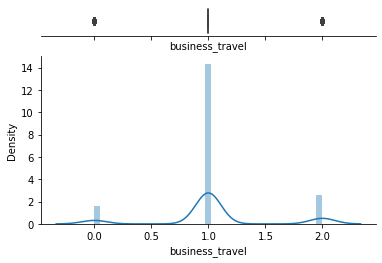

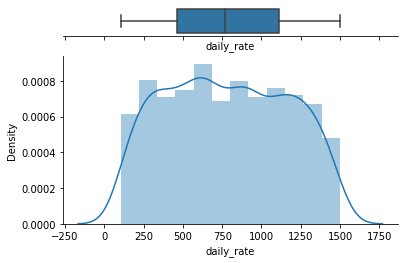

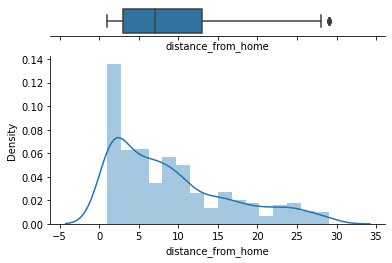

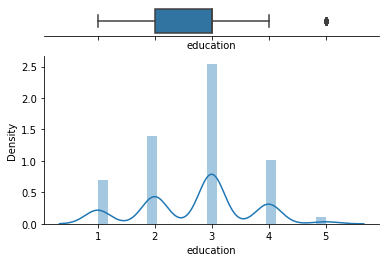

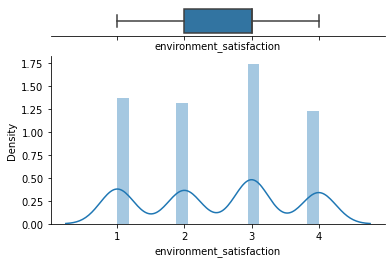

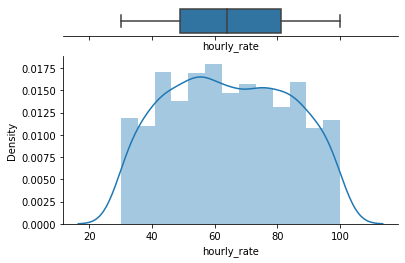

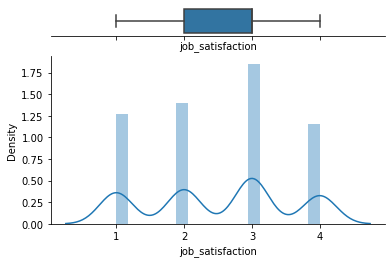

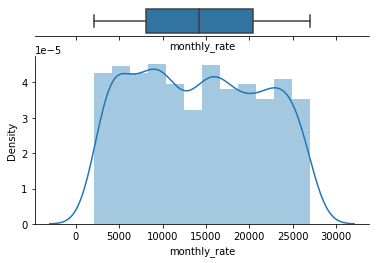

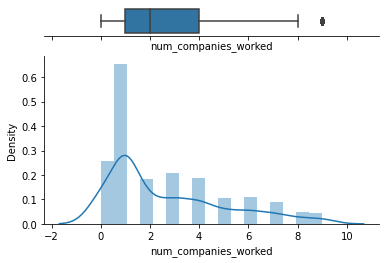

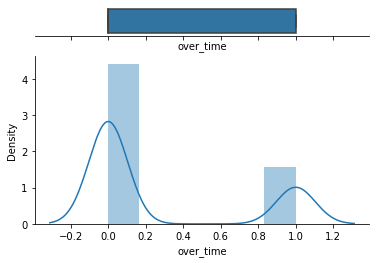

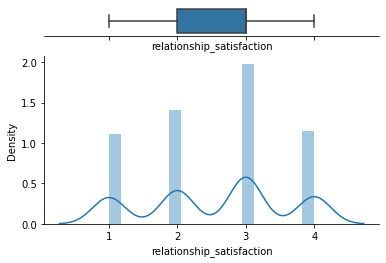

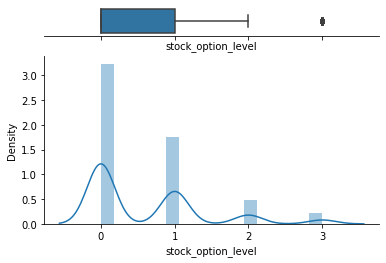

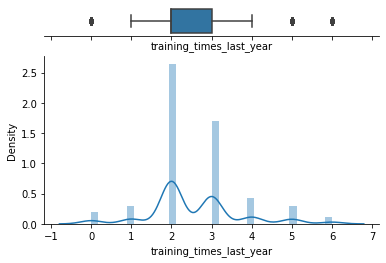

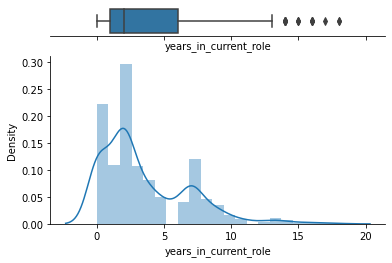

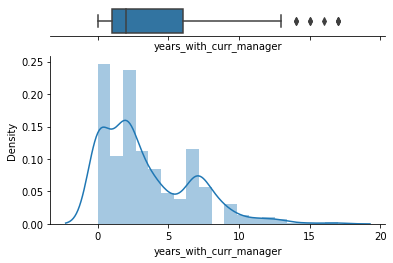

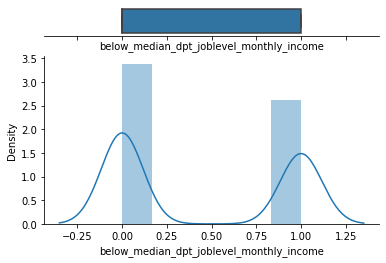

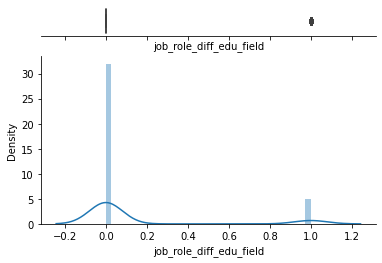

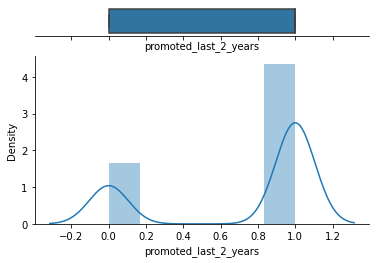

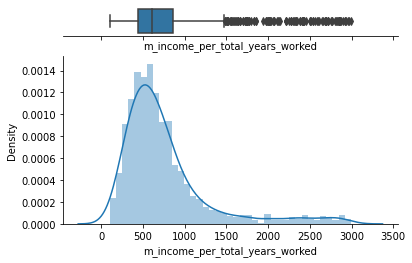

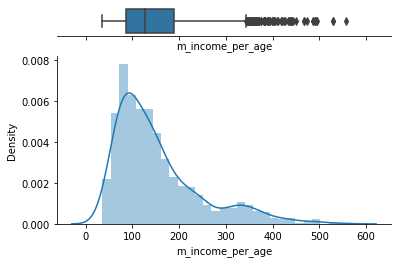

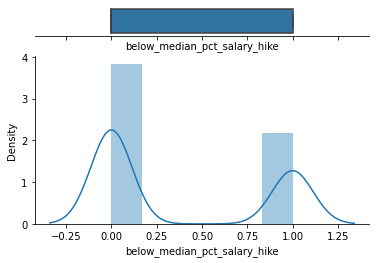

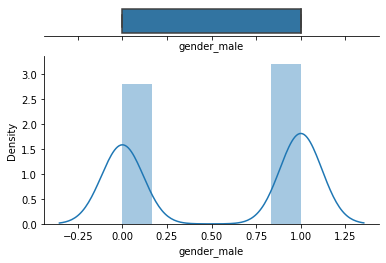

In [13]:
plt.figure(figsize = (10, 10))
for i, feature in enumerate(X_train_smote.columns.tolist()):
#     for i in plt.subplot(2, 2, i + 1):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(X_train_smote[feature], ax=ax_box)
    sns.distplot(X_train_smote[feature], ax=ax_hist)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True);

In [14]:
to_robust_scale = [
    'distance_from_home',
    'education',
    'num_companies_worked',
    'stock_option_level',
    'training_times_last_year',
    'years_in_current_role',
    'years_with_curr_manager',
    'm_income_per_total_years_worked',
    'm_income_per_age'
]

rb_scaler = RobustScaler()
X_train_smote[to_robust_scale] = rb_scaler.fit_transform(X_train_smote[to_robust_scale])
X_val[to_robust_scale] = rb_scaler.transform(X_val[to_robust_scale])

In [15]:
to_stand_scale = [
    set(X_train_smote.columns.tolist()) - set(to_robust_scale)
]


to_stand_scale = list(to_stand_scale[0])

In [16]:
stand_scaler = StandardScaler()
X_train_smote[to_stand_scale] = stand_scaler.fit_transform(X_train_smote[to_stand_scale])
X_val[to_stand_scale] = stand_scaler.transform(X_val[to_stand_scale])

In [17]:
X_train_smote

,business_travel,daily_rate,distance_from_home,education,environment_satisfaction,hourly_rate,job_satisfaction,monthly_rate,num_companies_worked,over_time,...,training_times_last_year,years_in_current_role,years_with_curr_manager,below_median_dpt_joblevel_monthly_income,job_role_diff_edu_field,promoted_last_2_years,m_income_per_total_years_worked,m_income_per_age,below_median_pct_salary_hike,gender_male
0,2.007224,-1.466808,-0.4,0.0,1.386785,-0.813352,0.467478,-0.551869,2.333333,1.671999,...,0.0,0.0,2.2,1.137463,2.519443,-1.626211,-0.279711,1.612967,1.328378,-1.069358
1,-0.110999,-1.333863,-0.5,2.0,1.386785,1.432708,0.467478,0.876180,1.333333,1.671999,...,-2.0,-0.4,-0.2,-0.879149,-0.396913,0.614926,-0.237075,-0.459038,1.328378,0.935141
2,-0.110999,1.022649,-0.4,0.0,-0.462262,0.701433,-0.484099,-1.462414,-0.333333,-0.598087,...,1.0,-0.4,-0.4,-0.879149,2.519443,0.614926,5.410607,-0.248918,-0.752798,-1.069358
3,-0.110999,-1.615394,-0.3,-2.0,0.462262,-0.708884,-0.484099,-0.184334,-0.333333,-0.598087,...,1.0,0.0,0.0,-0.879149,-0.396913,0.614926,1.180161,0.153342,1.328378,-1.069358
4,-0.110999,0.136350,-0.2,1.0,0.462262,-0.082076,1.419055,0.082432,-0.333333,-0.598087,...,0.0,0.0,0.0,-0.879149,-0.396913,0.614926,2.039808,-0.383338,1.328378,-1.069358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369,-0.110999,0.151991,-0.1,0.0,0.462262,0.022391,-1.435676,1.326923,0.666667,-0.598087,...,1.0,0.0,0.0,1.137463,-0.396913,-1.626211,-0.691208,-0.458839,-0.752798,0.935141
1370,-0.110999,-0.682173,-0.2,0.0,-1.386785,-0.813352,-0.484099,0.080760,0.000000,-0.598087,...,0.0,-0.2,0.4,-0.879149,-0.396913,-1.626211,1.023023,0.541657,1.328378,-1.069358
1371,-0.110999,0.615994,1.2,-1.0,-0.462262,-1.492393,-0.484099,0.668789,-0.333333,-0.598087,...,-1.0,-0.4,-0.4,-0.879149,-0.396913,0.614926,4.316442,-0.318360,-0.752798,0.935141
1372,-0.110999,-1.211345,-0.5,0.0,-0.462262,0.649199,-1.435676,1.691810,1.000000,1.671999,...,0.0,-0.2,-0.2,-0.879149,-0.396913,0.614926,2.444808,1.002506,1.328378,-1.069358


## Models

### Logistic Regression

In [18]:
log_model = LogisticRegression(random_state = 0)
log_model.fit(X_train_smote, y_train_smote)

LogisticRegression(random_state=0)

In [19]:
y_pred_logm = log_model.predict(X_val)

In [20]:
print(classification_report(y_val, y_pred_logm))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       236
           1       0.35      0.55      0.43        40

    accuracy                           0.79       276
   macro avg       0.63      0.69      0.65       276
weighted avg       0.83      0.79      0.80       276



#### Studying threshold values

In [21]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = log_model.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    print(threshold, '================================================== \n', 
          classification_report(y_val, predicted))

0.0 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.01 ================================================== 
               precision    recall  f1-score   support

           0       1.00      0.06      0.11       236
           1       0.15      1.00      0.26        40

    accuracy                           0.20       276
   macro avg       0.58      0.53      0.19       276
weighted avg       0.88      0.20      0.13       276

0.02 ================================================== 
               precision    recall  f1-score   support

           0       0.96      0.10      0.18       236
           1       0.16      0.97      0.27        40

    accur

0.29 ================================================== 
               precision    recall  f1-score   support

           0       0.93      0.63      0.75       236
           1       0.24      0.70      0.36        40

    accuracy                           0.64       276
   macro avg       0.58      0.66      0.55       276
weighted avg       0.83      0.64      0.69       276

0.3 ================================================== 
               precision    recall  f1-score   support

           0       0.93      0.63      0.75       236
           1       0.24      0.70      0.36        40

    accuracy                           0.64       276
   macro avg       0.58      0.66      0.55       276
weighted avg       0.83      0.64      0.69       276

0.31 ================================================== 
               precision    recall  f1-score   support

           0       0.93      0.63      0.75       236
           1       0.24      0.70      0.36        40

    accur

0.6 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       236
           1       0.38      0.42      0.40        40

    accuracy                           0.82       276
   macro avg       0.64      0.65      0.65       276
weighted avg       0.82      0.82      0.82       276

0.61 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.89      0.89       236
           1       0.39      0.42      0.40        40

    accuracy                           0.82       276
   macro avg       0.64      0.66      0.65       276
weighted avg       0.83      0.82      0.82       276

0.62 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.89      0.89       236
           1       0.38      0.40      0.39        40

    accur

0.98 ================================================== 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       236
           1       0.00      0.00      0.00        40

    accuracy                           0.86       276
   macro avg       0.43      0.50      0.46       276
weighted avg       0.73      0.86      0.79       276

0.99 ================================================== 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       236
           1       0.00      0.00      0.00        40

    accuracy                           0.86       276
   macro avg       0.43      0.50      0.46       276
weighted avg       0.73      0.86      0.79       276



In [22]:
cv_log_model = cross_validate(log_model, X_train_smote, y_train_smote, cv = 10, scoring = ['recall', 'f1'])
print('Recall  : ', cv_log_model['test_recall'].mean())
print('F1-score: ', cv_log_model['test_f1'].mean())

Recall  :  0.7893222506393862
F1-score:  0.7794481020128445


#### RandomSearch

In [23]:
rand_params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': loguniform(0.01, 1),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'tol': loguniform(1e-4, 1e-2),
    'l1_ratio': loguniform(0.001, .01)
}

rand_search_log_model = RandomizedSearchCV(log_model, param_distributions = rand_params,
                                           cv = 10, scoring = ['recall', 'f1'], refit = 'f1',
                                           verbose = 1, n_jobs = -1)

In [24]:
rand_search_log_model.fit(X_train_smote, y_train_smote)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished


RandomizedSearchCV(cv=10, estimator=LogisticRegression(random_state=0),
                   n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14818d590>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x148f9b210>,
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag', 'saga'],
                                        'tol': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1249def90>},
                   refit='f1', scoring=['recall', 'f1'], verbose=1)

In [25]:
rand_search_log_model.best_score_ # What is this shit!?

0.7843741320551124

In [26]:
rand_search_log_model.best_params_

{'C': 0.02183667359800067,
 'l1_ratio': 0.0015024582607101986,
 'penalty': 'l2',
 'solver': 'newton-cg',
 'tol': 0.00045591992961078293}

In [27]:
y_pred_rand_logm = rand_search_log_model.predict(X_val)

In [28]:
print(classification_report(y_val, y_pred_rand_logm))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87       236
           1       0.34      0.53      0.42        40

    accuracy                           0.79       276
   macro avg       0.63      0.68      0.64       276
weighted avg       0.83      0.79      0.80       276



In [29]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = rand_search_log_model.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    print(threshold, '================================================== \n', 
          classification_report(y_val, predicted))

0.0 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.01 ================================================== 
               precision    recall  f1-score   support

           0       1.00      0.00      0.01       236
           1       0.15      1.00      0.25        40

    accuracy                           0.15       276
   macro avg       0.57      0.50      0.13       276
weighted avg       0.88      0.15      0.04       276

0.02 ================================================== 
               precision    recall  f1-score   support

           0       1.00      0.02      0.04       236
           1       0.15      1.00      0.26        40

    accur

0.44 ================================================== 
               precision    recall  f1-score   support

           0       0.92      0.73      0.81       236
           1       0.28      0.62      0.39        40

    accuracy                           0.71       276
   macro avg       0.60      0.68      0.60       276
weighted avg       0.83      0.71      0.75       276

0.45 ================================================== 
               precision    recall  f1-score   support

           0       0.91      0.75      0.82       236
           1       0.28      0.57      0.38        40

    accuracy                           0.72       276
   macro avg       0.60      0.66      0.60       276
weighted avg       0.82      0.72      0.76       276

0.46 ================================================== 
               precision    recall  f1-score   support

           0       0.91      0.77      0.84       236
           1       0.30      0.57      0.39        40

    accu

0.7000000000000001 ================================================== 
               precision    recall  f1-score   support

           0       0.87      0.94      0.90       236
           1       0.33      0.17      0.23        40

    accuracy                           0.83       276
   macro avg       0.60      0.56      0.57       276
weighted avg       0.79      0.83      0.81       276

0.71 ================================================== 
               precision    recall  f1-score   support

           0       0.87      0.94      0.91       236
           1       0.35      0.17      0.23        40

    accuracy                           0.83       276
   macro avg       0.61      0.56      0.57       276
weighted avg       0.80      0.83      0.81       276

0.72 ================================================== 
               precision    recall  f1-score   support

           0       0.87      0.96      0.91       236
           1       0.41      0.17      0.25      

0.99 ================================================== 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       236
           1       0.00      0.00      0.00        40

    accuracy                           0.86       276
   macro avg       0.43      0.50      0.46       276
weighted avg       0.73      0.86      0.79       276



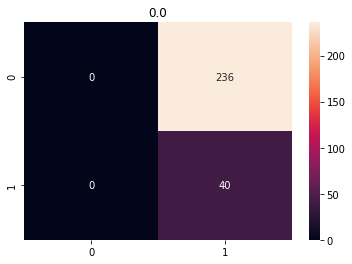

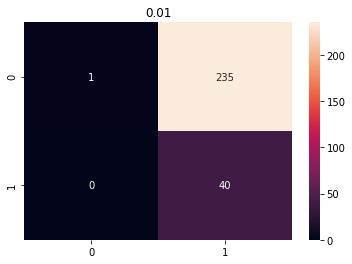

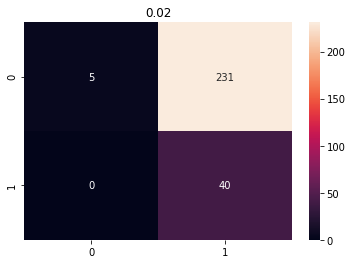

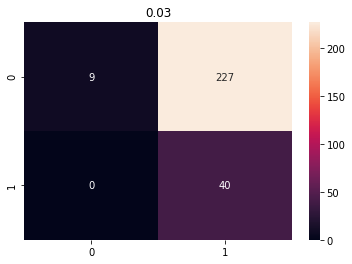

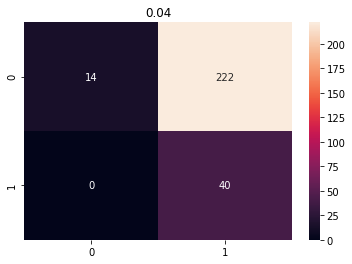

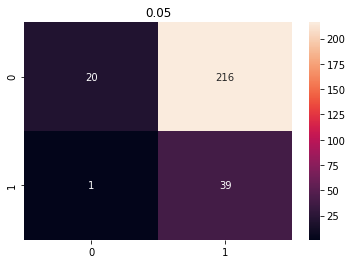

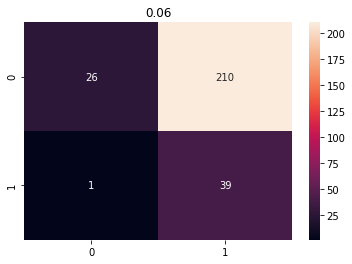

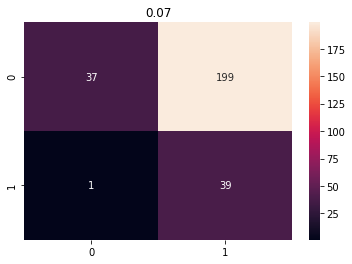

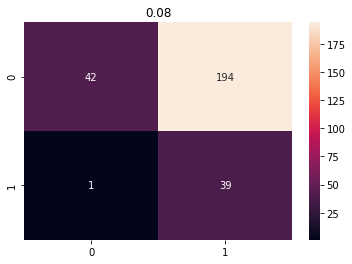

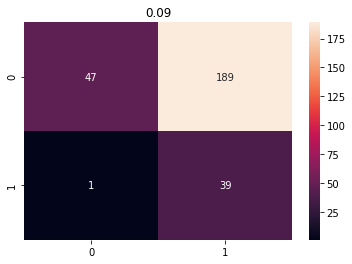

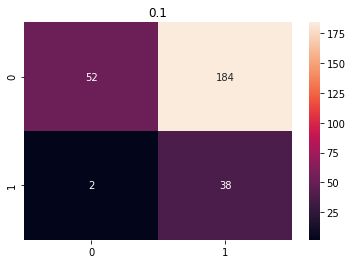

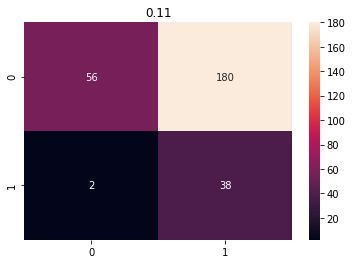

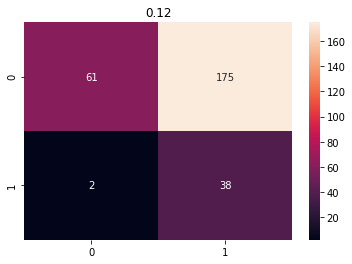

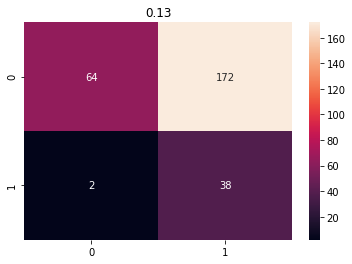

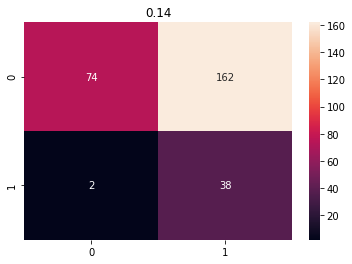

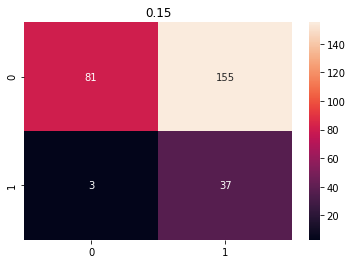

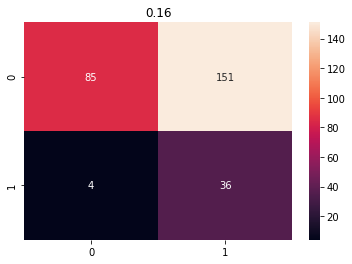

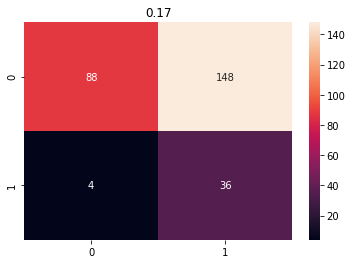

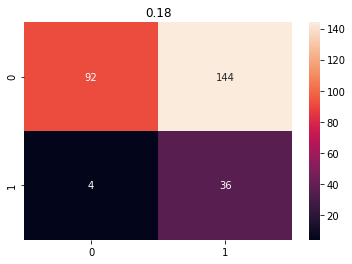

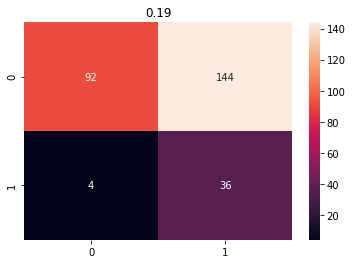

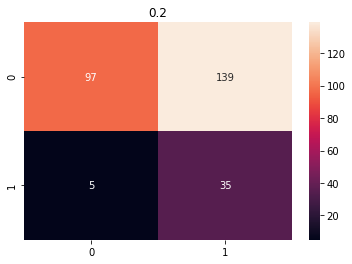

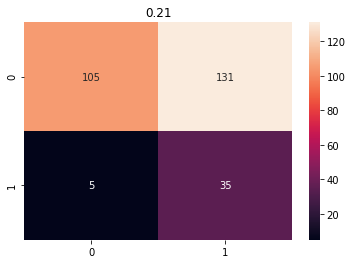

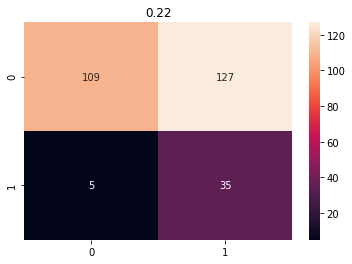

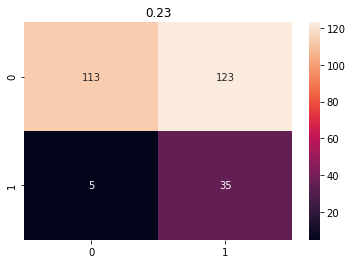

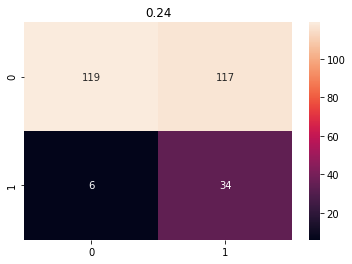

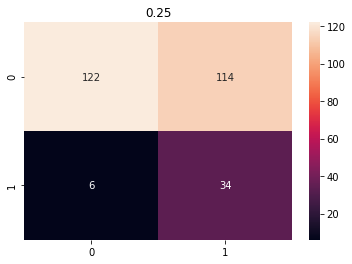

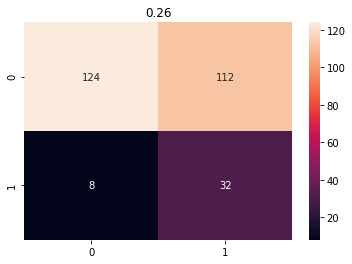

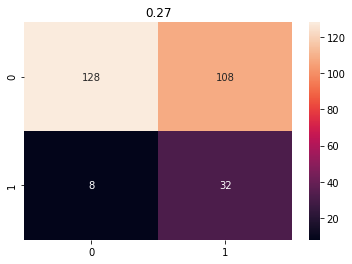

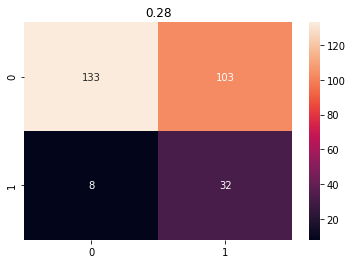

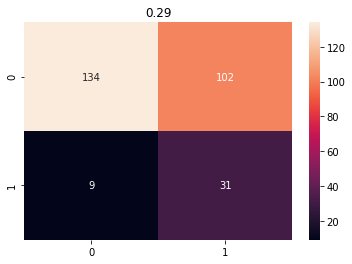

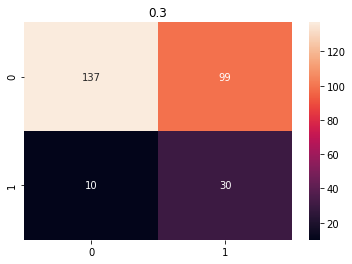

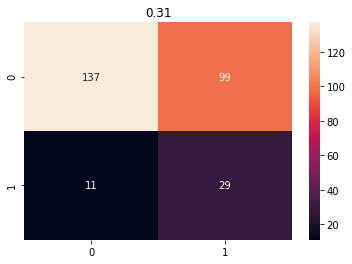

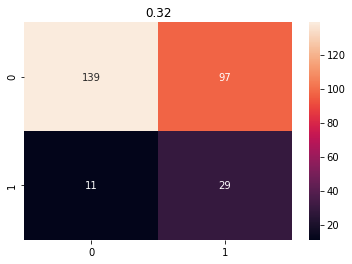

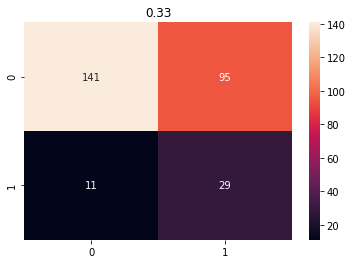

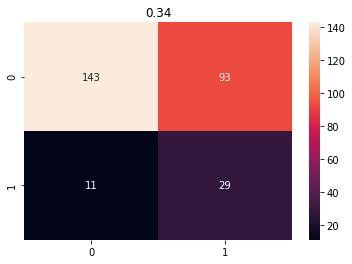

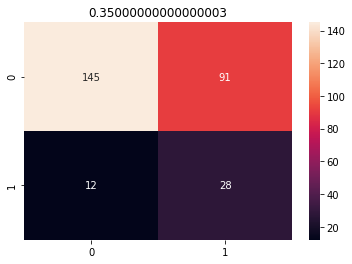

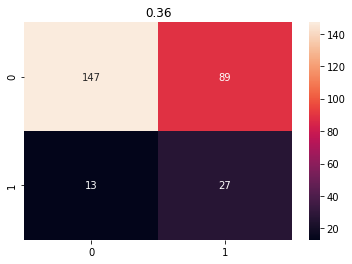

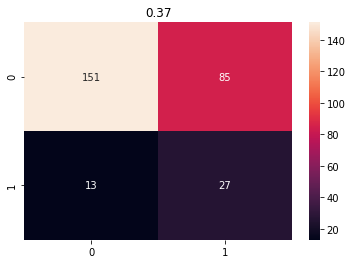

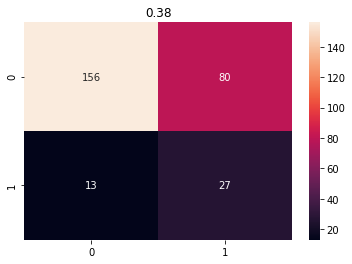

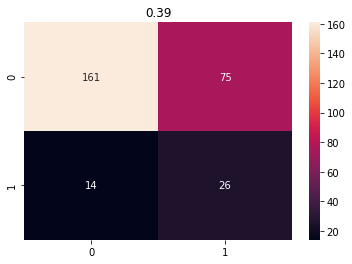

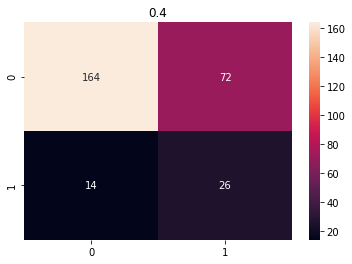

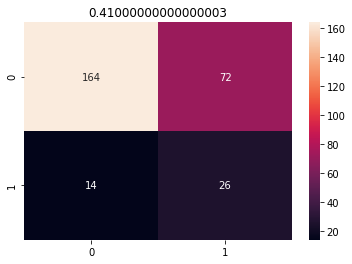

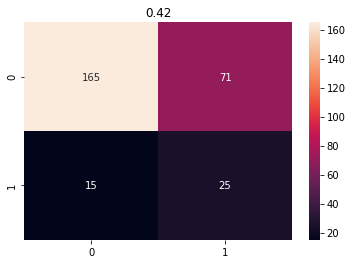

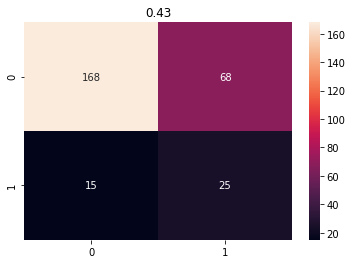

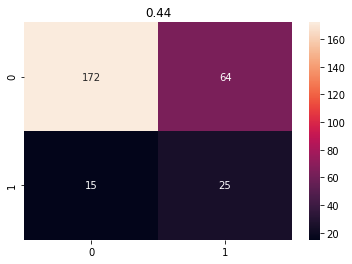

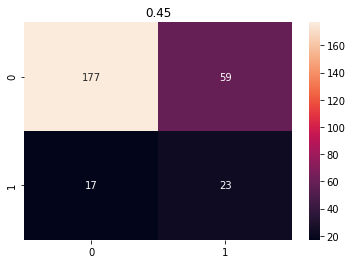

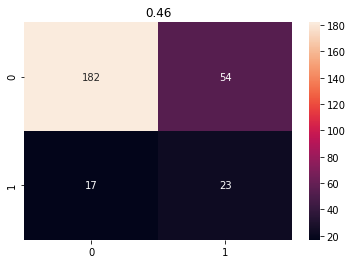

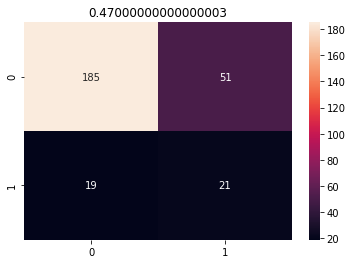

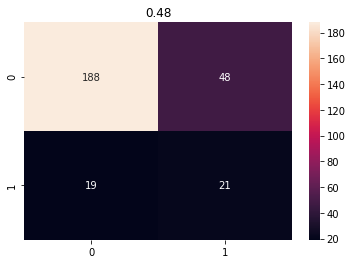

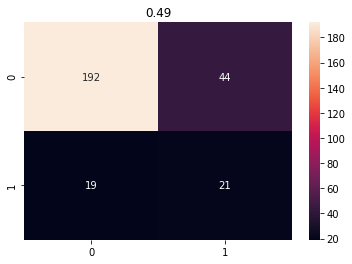

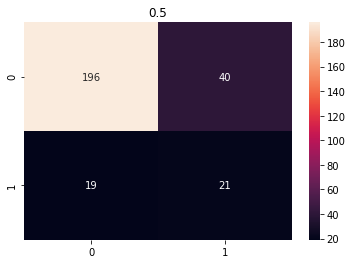

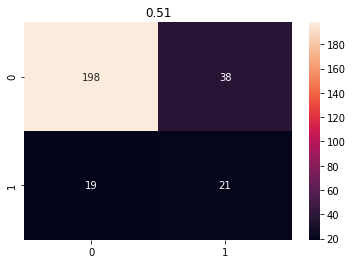

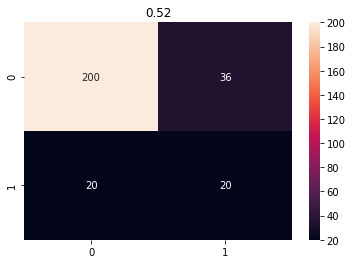

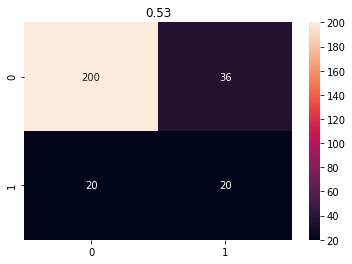

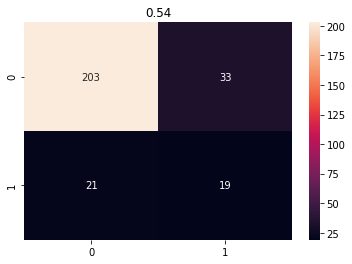

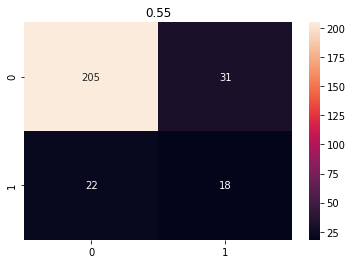

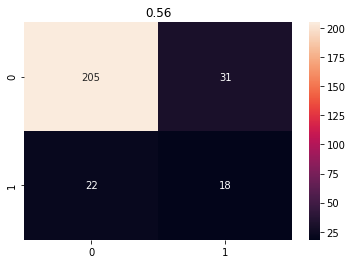

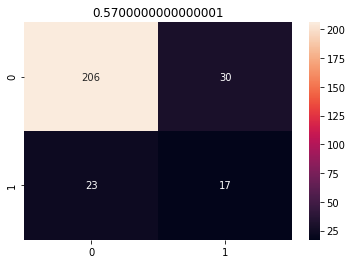

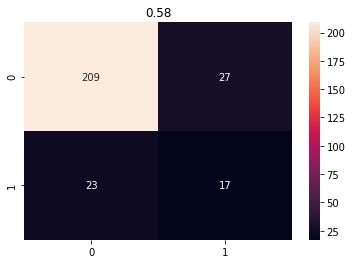

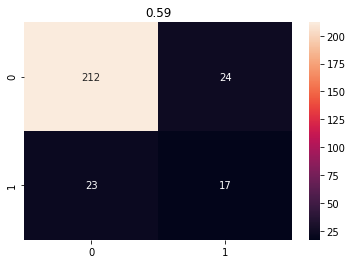

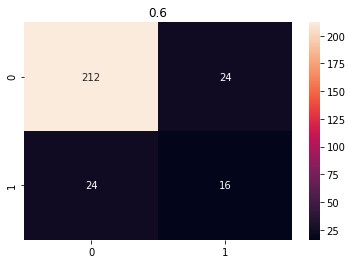

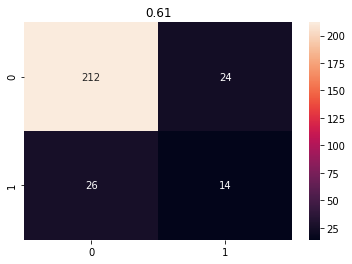

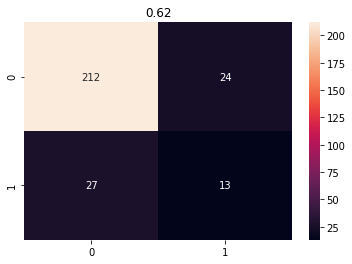

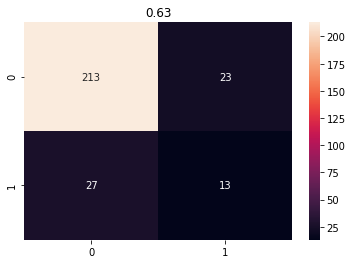

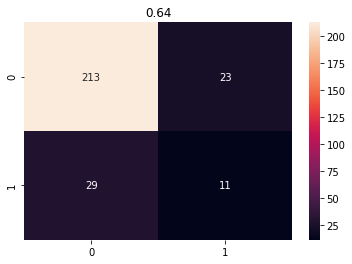

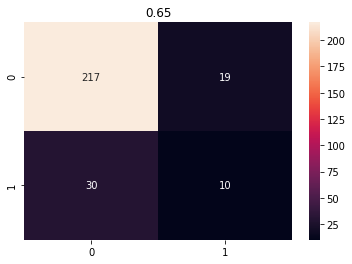

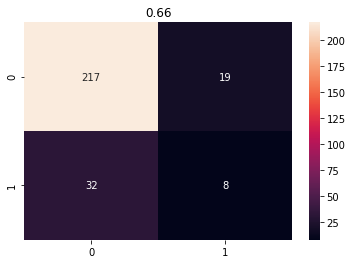

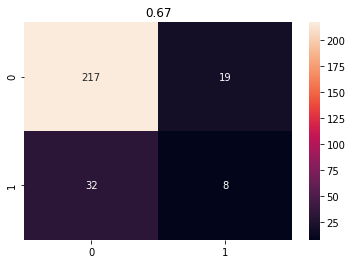

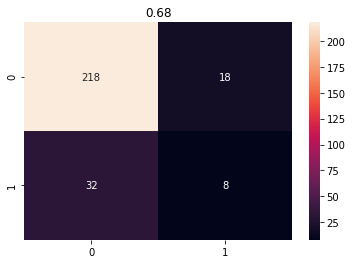

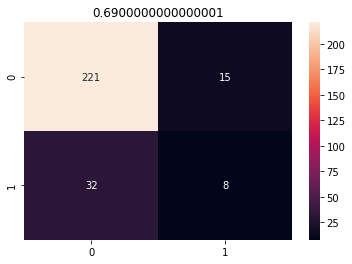

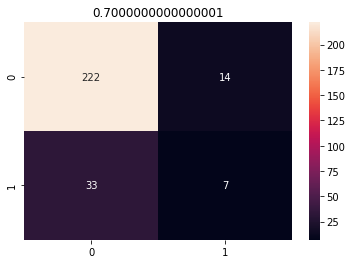

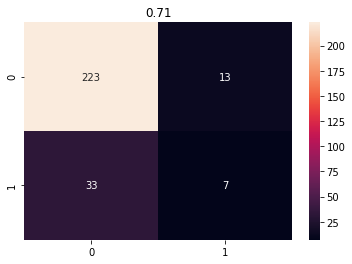

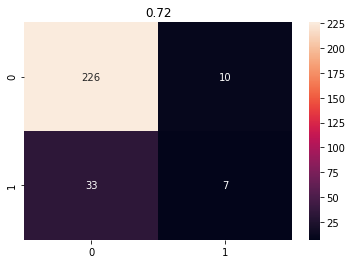

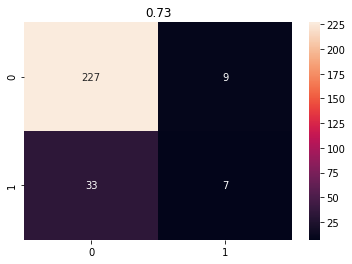

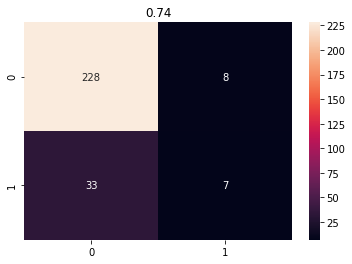

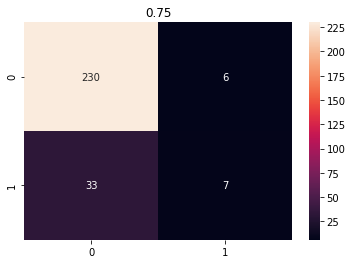

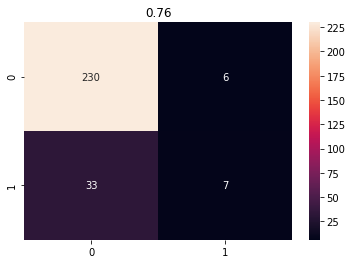

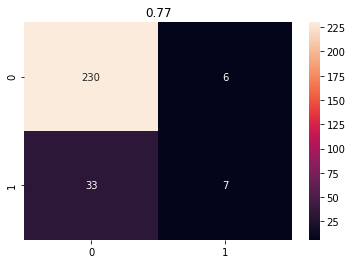

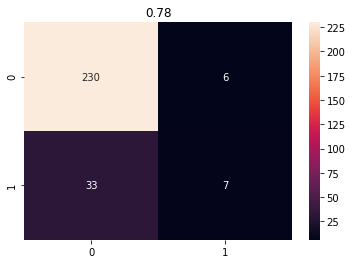

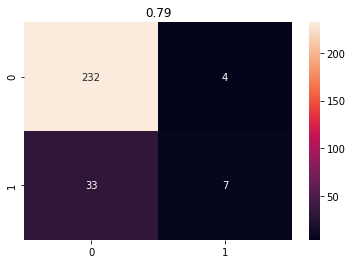

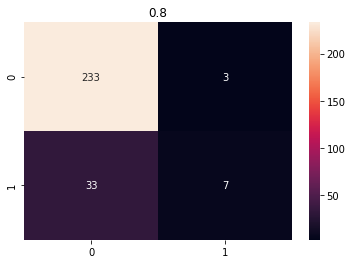

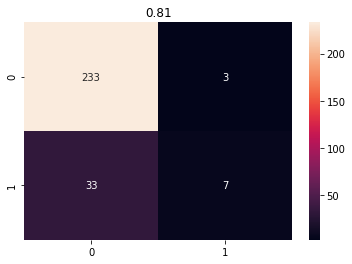

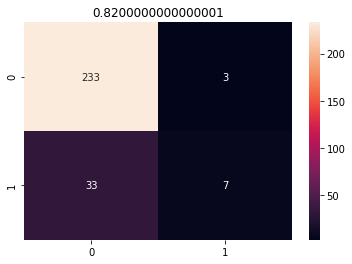

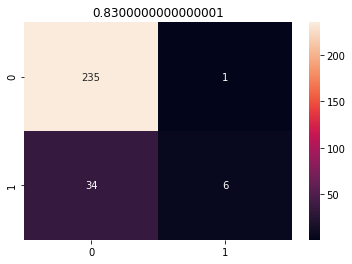

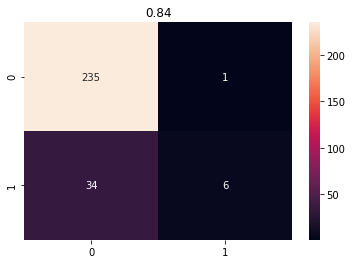

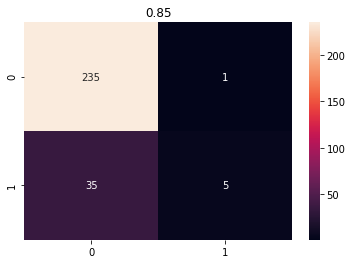

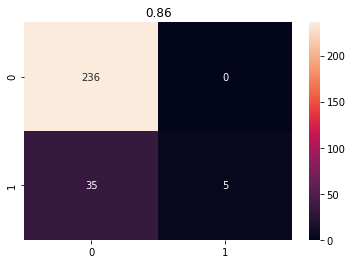

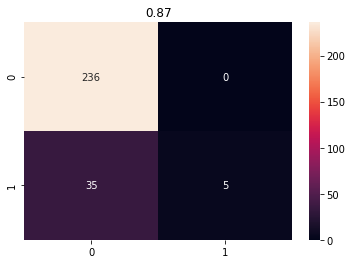

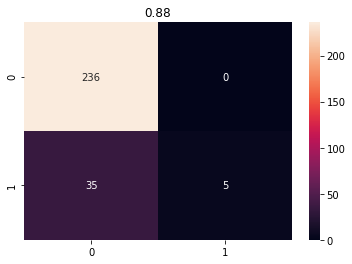

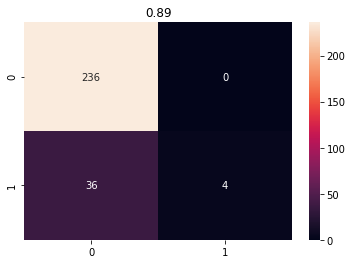

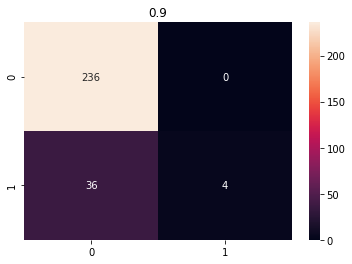

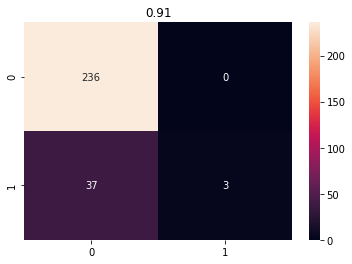

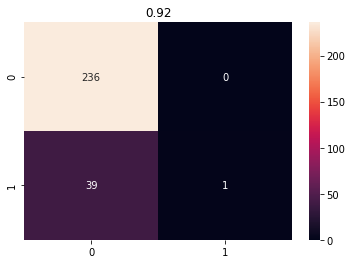

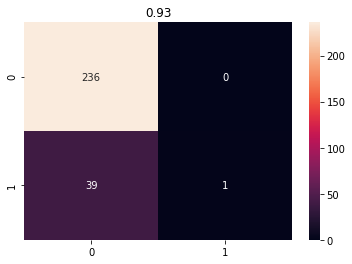

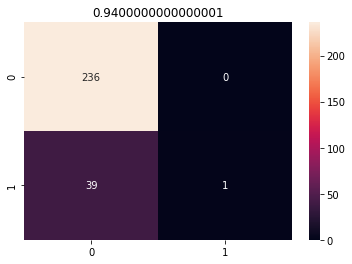

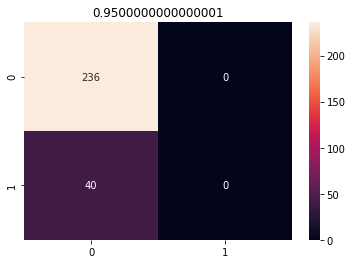

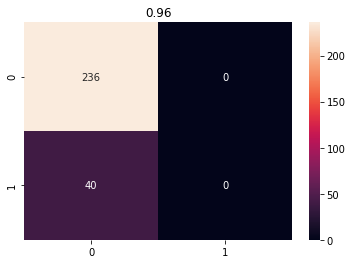

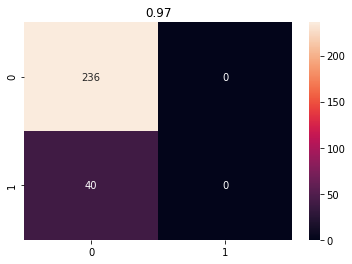

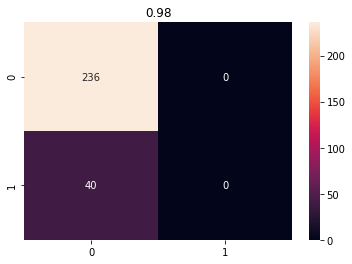

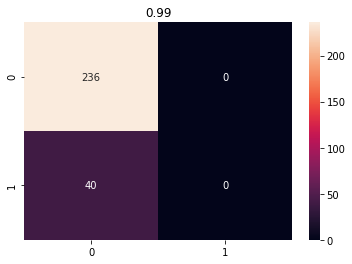

In [53]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = rand_search_log_model.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
#     print(threshold, '================================================== \n', 
#           classification_report(y_val, predicted))
    plt.title(threshold)
    sns.heatmap(confusion_matrix(y_val, predicted), annot = True, fmt="g")
    plt.show()

In [31]:
1.2e02+2 

122.0

### RandomForestClassifier

In [32]:
rf_model = RandomForestClassifier(random_state = 0)
rf_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=0)

In [33]:
y_pred_rf = rf_model.predict(X_val)

In [34]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = rf_model.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    print(threshold, '================================================== \n', 
          classification_report(y_val, predicted))

0.0 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.01 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.02 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accur

0.23 ================================================== 
               precision    recall  f1-score   support

           0       0.95      0.53      0.68       236
           1       0.23      0.82      0.36        40

    accuracy                           0.57       276
   macro avg       0.59      0.68      0.52       276
weighted avg       0.84      0.57      0.63       276

0.24 ================================================== 
               precision    recall  f1-score   support

           0       0.94      0.55      0.69       236
           1       0.23      0.78      0.35        40

    accuracy                           0.58       276
   macro avg       0.58      0.66      0.52       276
weighted avg       0.83      0.58      0.64       276

0.25 ================================================== 
               precision    recall  f1-score   support

           0       0.93      0.59      0.72       236
           1       0.23      0.72      0.35        40

    accu

0.51 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       236
           1       0.47      0.23      0.31        40

    accuracy                           0.85       276
   macro avg       0.68      0.59      0.61       276
weighted avg       0.82      0.85      0.83       276

0.52 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       236
           1       0.50      0.20      0.29        40

    accuracy                           0.86       276
   macro avg       0.69      0.58      0.60       276
weighted avg       0.82      0.86      0.83       276

0.53 ================================================== 
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       236
           1       0.50      0.17      0.26        40

    accu

0.8 ================================================== 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       236
           1       0.67      0.05      0.09        40

    accuracy                           0.86       276
   macro avg       0.76      0.52      0.51       276
weighted avg       0.83      0.86      0.80       276

0.81 ================================================== 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       236
           1       0.67      0.05      0.09        40

    accuracy                           0.86       276
   macro avg       0.76      0.52      0.51       276
weighted avg       0.83      0.86      0.80       276

0.8200000000000001 ================================================== 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       236
           1       0.50      0.03      0.05       

In [35]:
rf_params = {
#     'n_estimators': np.random.randint(100, 150),
    'criterion': ["gini", "entropy"],
    'max_features': ["auto", "sqrt", "log2"],
#     'max_leaf_nodes': np.random.randint(1, 100),
    'min_impurity_decrease': loguniform(0.01, 1),
    'bootstrap': [True, False],
    'ccp_alpha': loguniform(0.01, 1),
    'max_samples': loguniform(0.5, .75)
}

rand_rf_model = RandomizedSearchCV(rf_model, param_distributions = rf_params,
                                   cv = 10, scoring = ['recall', 'f1'], refit = 'f1',
                                   verbose = 1, n_jobs = -1)

In [36]:
rand_rf_model.fit(X_train_smote, y_train_smote)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.0s finished


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=0),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14820ea10>,
                                        'criterion': ['gini', 'entropy'],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14820ea50>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14820ef10>},
                   refit='f1', scoring=['recall', 'f1'], verbose=1)

In [37]:
rand_rf_model.best_params_

{'bootstrap': True,
 'ccp_alpha': 0.02178275284312457,
 'criterion': 'entropy',
 'max_features': 'log2',
 'max_samples': 0.6278412866648251,
 'min_impurity_decrease': 0.10397231685363653}

In [38]:
y_pred_rf_model = rand_rf_model.predict(X_val)

In [39]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = rand_rf_model.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    print(threshold, '================================================== \n', 
          classification_report(y_val, predicted))

0.0 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.01 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.02 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accur

0.24 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.25 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.26 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accu

0.5 ================================================== 
               precision    recall  f1-score   support

           0       0.91      0.61      0.73       236
           1       0.22      0.65      0.33        40

    accuracy                           0.61       276
   macro avg       0.56      0.63      0.53       276
weighted avg       0.81      0.61      0.67       276

0.51 ================================================== 
               precision    recall  f1-score   support

           0       0.91      0.61      0.73       236
           1       0.22      0.65      0.33        40

    accuracy                           0.61       276
   macro avg       0.56      0.63      0.53       276
weighted avg       0.81      0.61      0.67       276

0.52 ================================================== 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       236
           1       0.00      0.00      0.00        40

    accur

0.74 ================================================== 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       236
           1       0.00      0.00      0.00        40

    accuracy                           0.86       276
   macro avg       0.43      0.50      0.46       276
weighted avg       0.73      0.86      0.79       276

0.75 ================================================== 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       236
           1       0.00      0.00      0.00        40

    accuracy                           0.86       276
   macro avg       0.43      0.50      0.46       276
weighted avg       0.73      0.86      0.79       276

0.76 ================================================== 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       236
           1       0.00      0.00      0.00        40

    accu

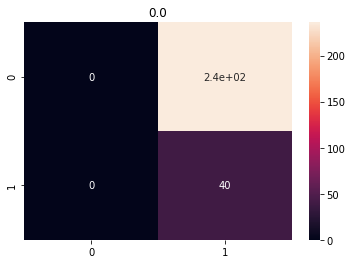

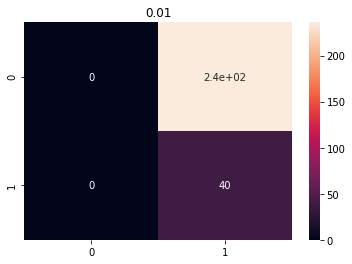

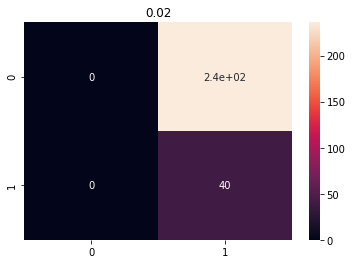

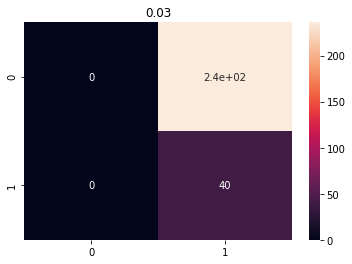

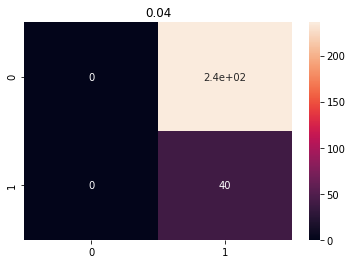

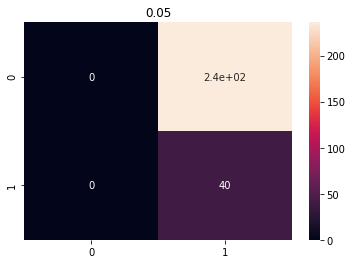

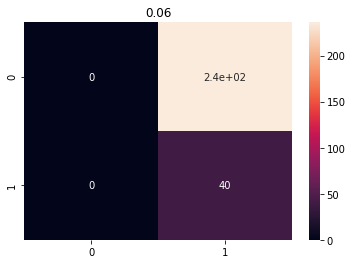

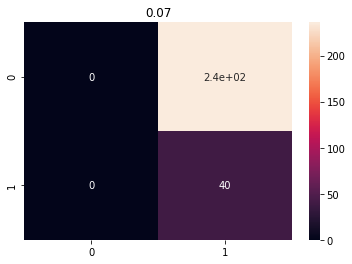

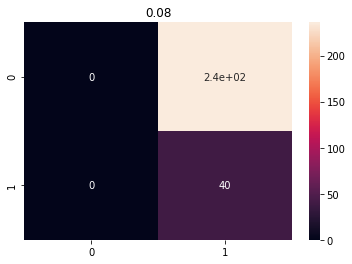

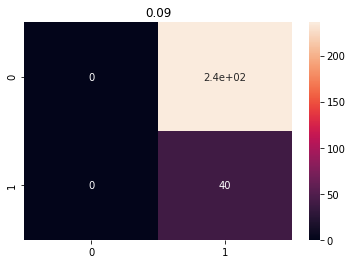

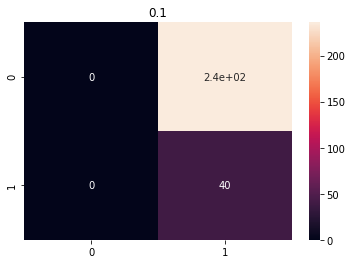

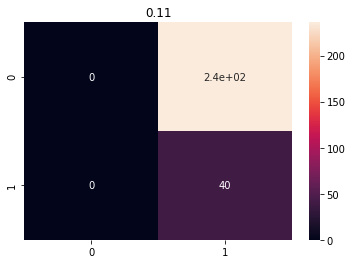

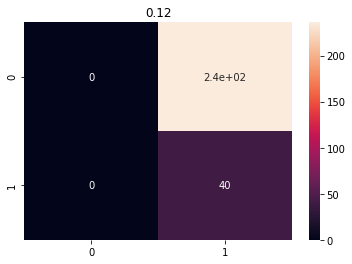

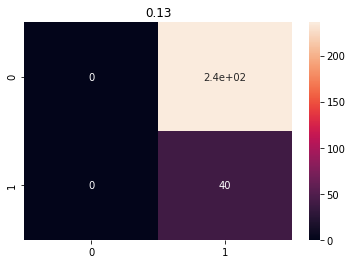

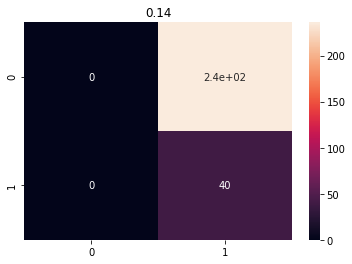

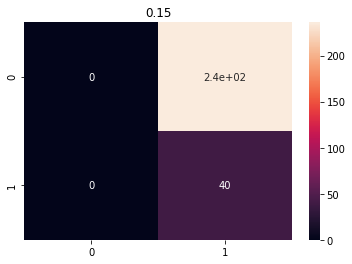

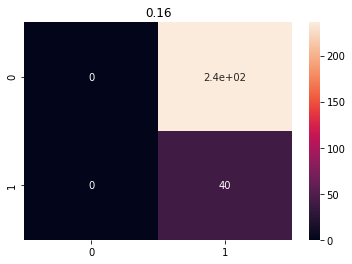

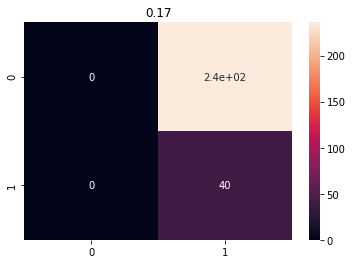

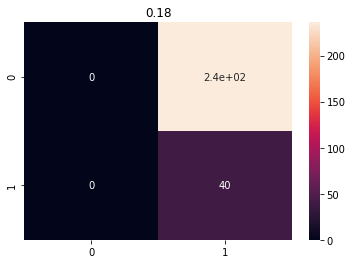

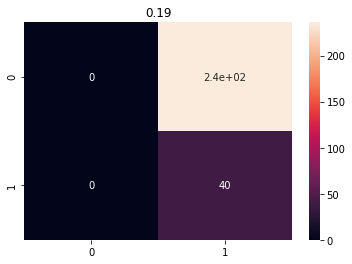

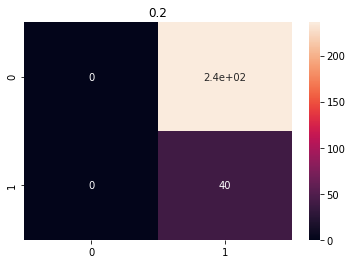

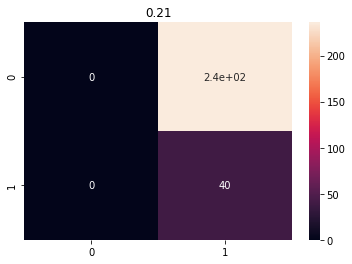

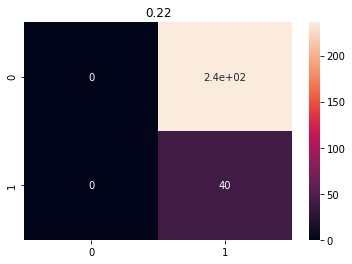

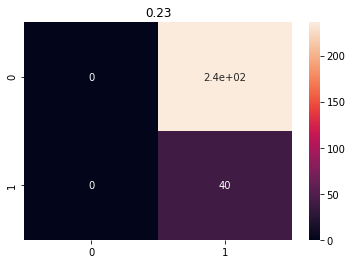

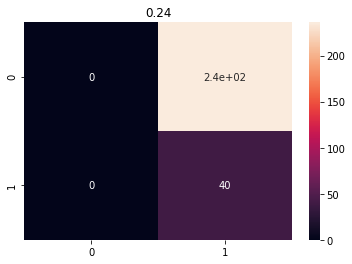

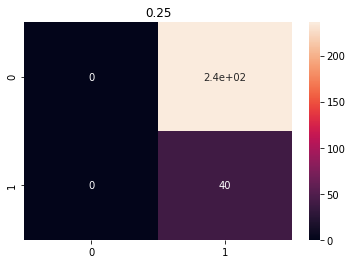

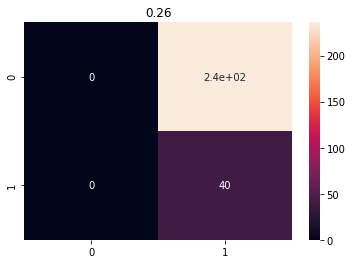

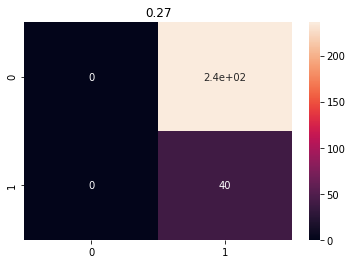

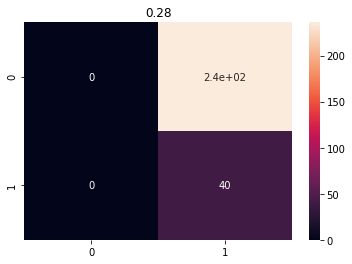

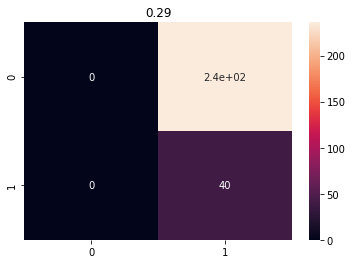

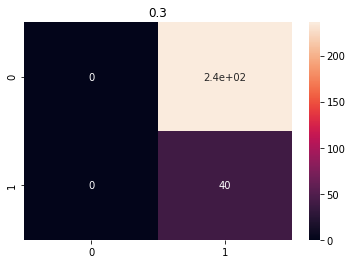

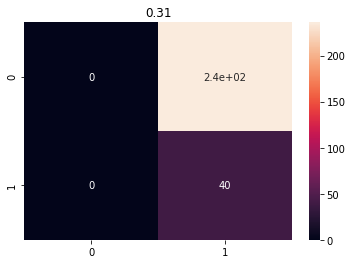

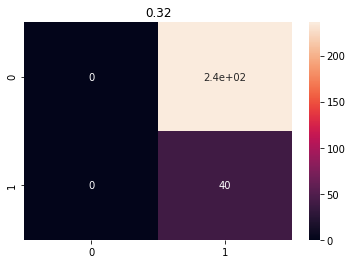

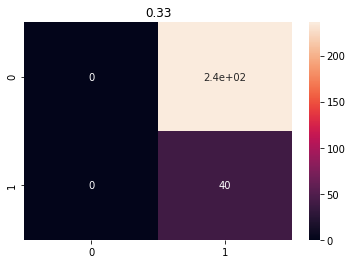

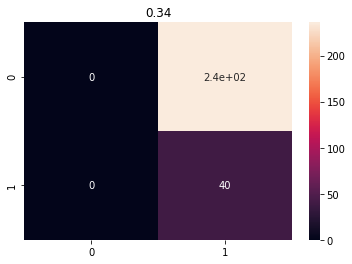

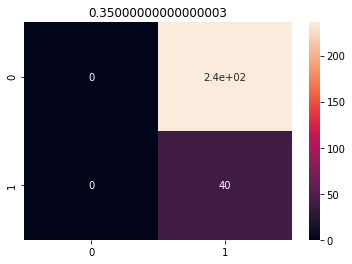

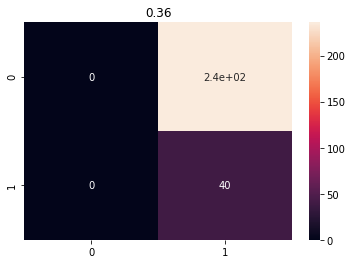

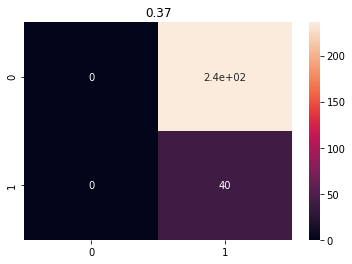

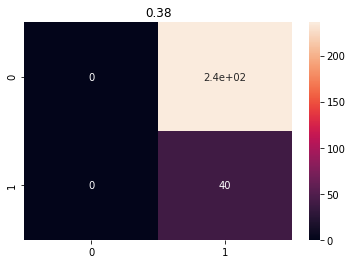

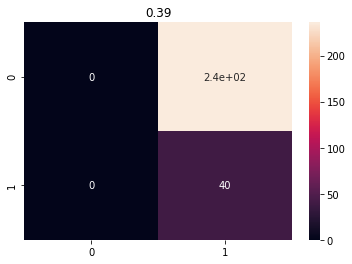

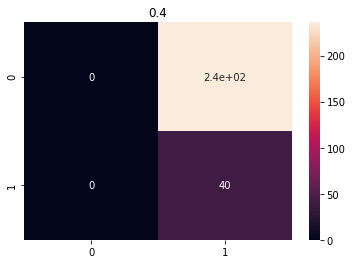

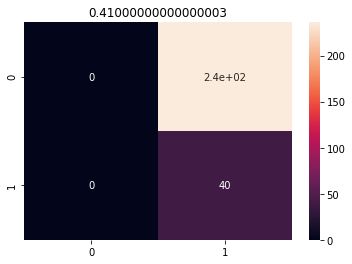

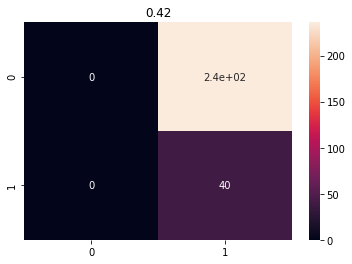

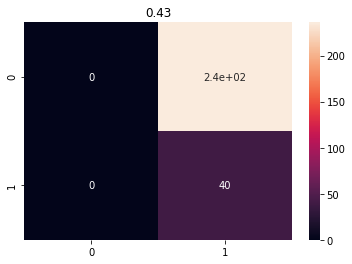

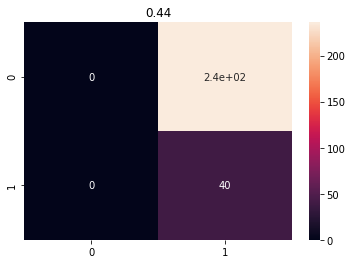

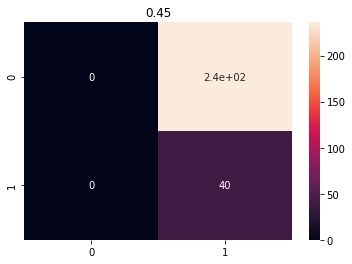

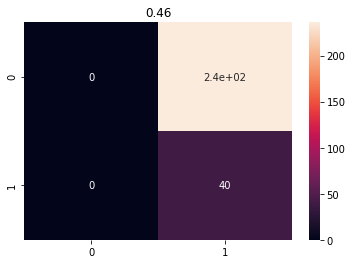

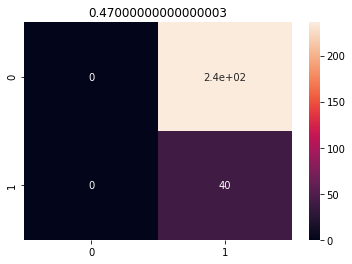

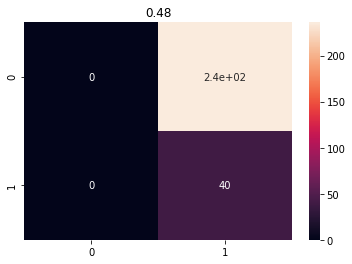

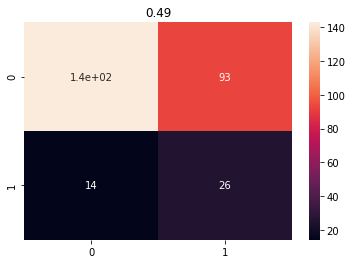

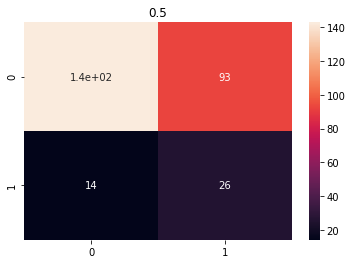

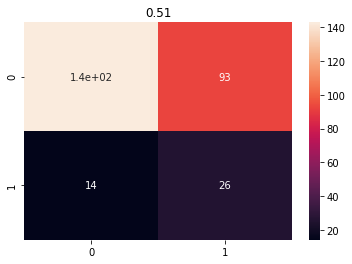

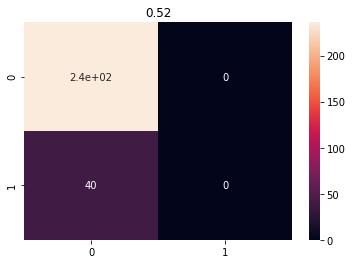

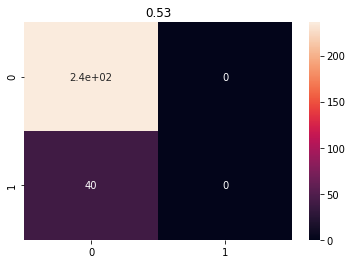

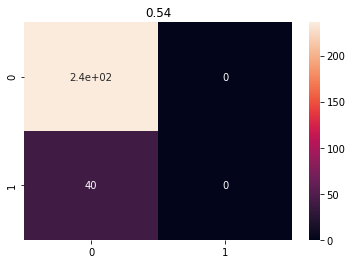

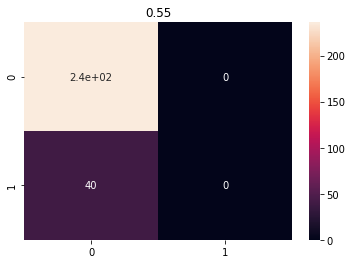

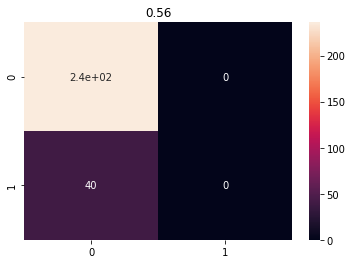

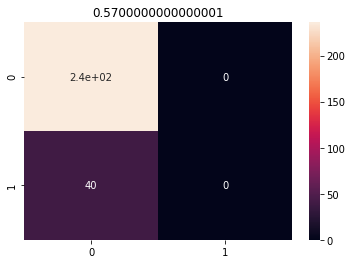

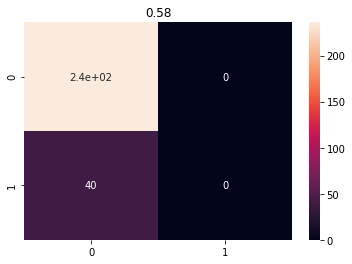

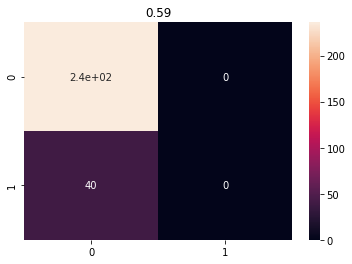

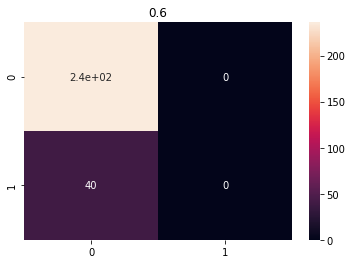

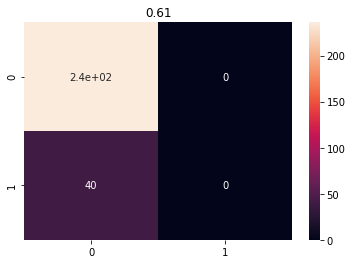

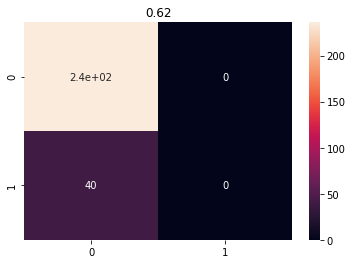

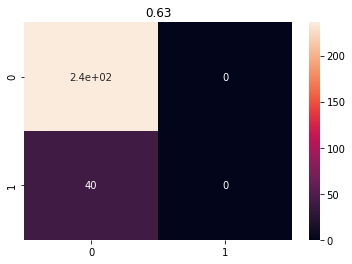

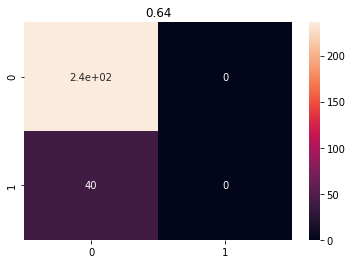

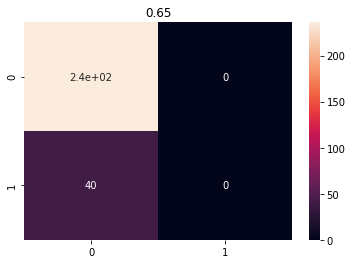

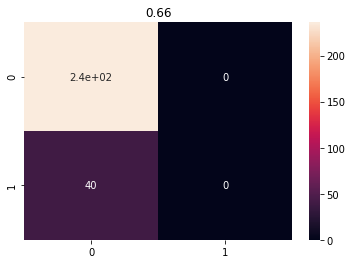

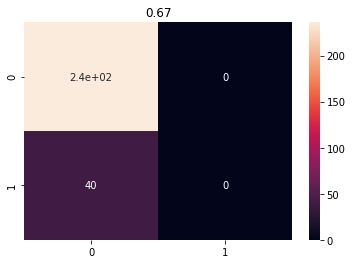

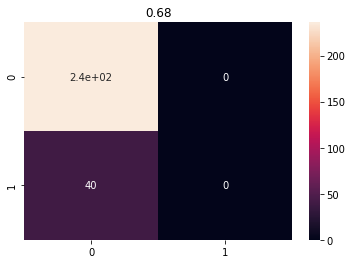

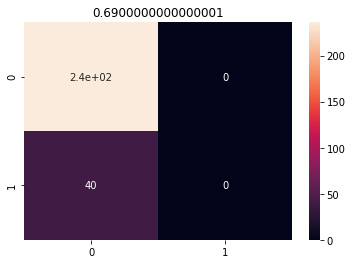

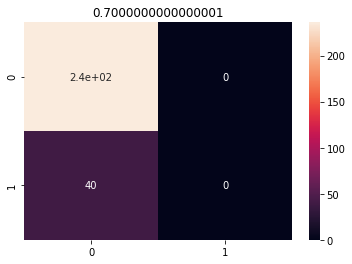

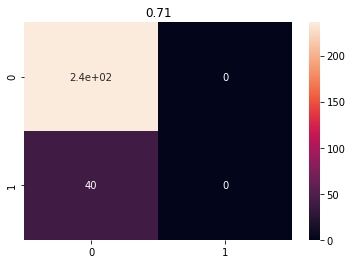

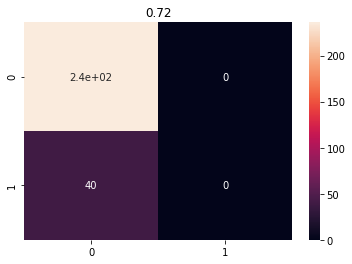

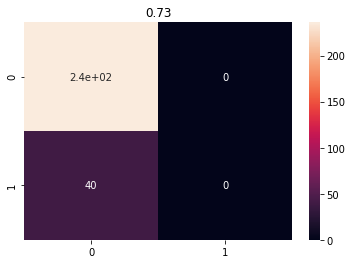

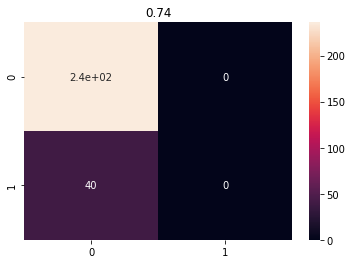

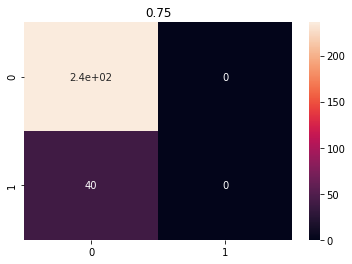

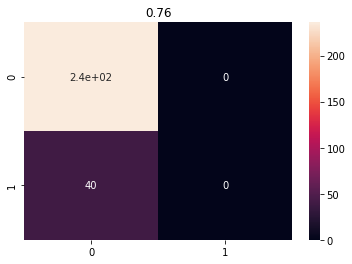

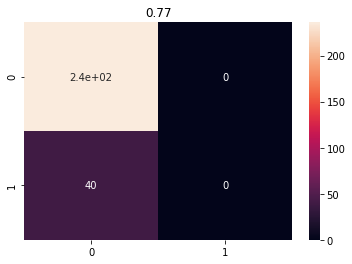

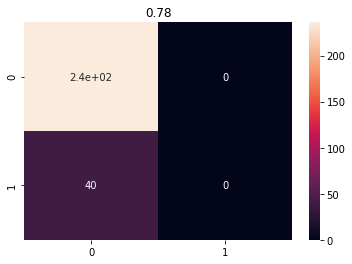

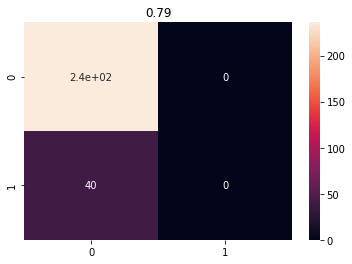

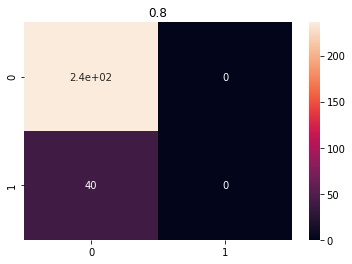

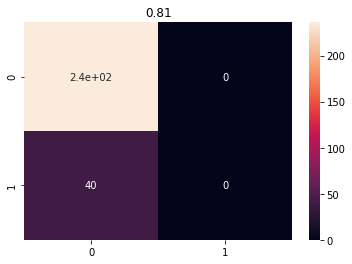

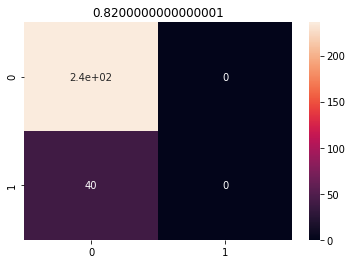

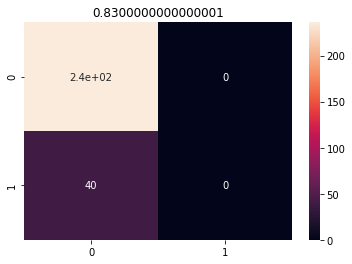

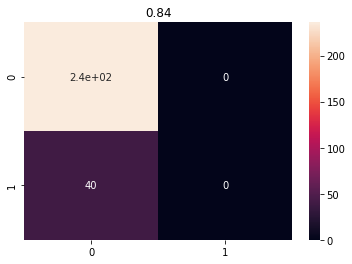

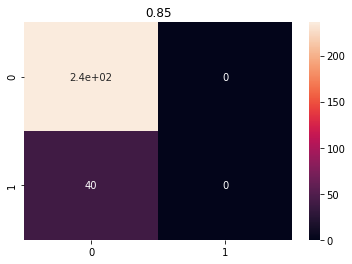

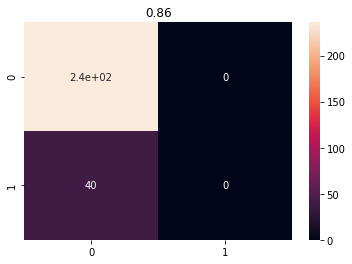

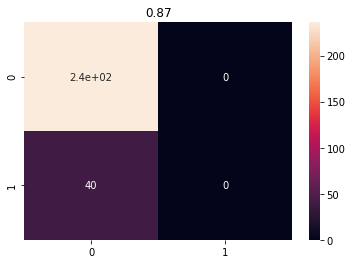

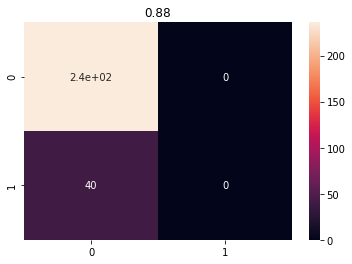

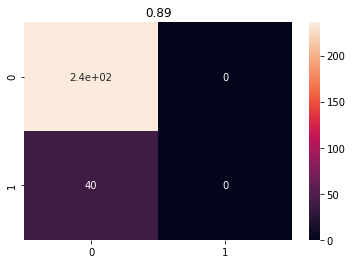

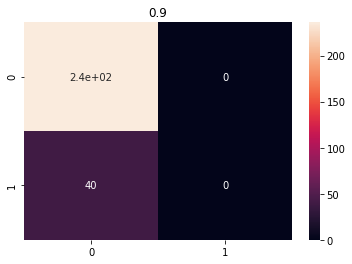

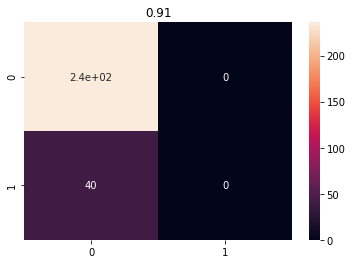

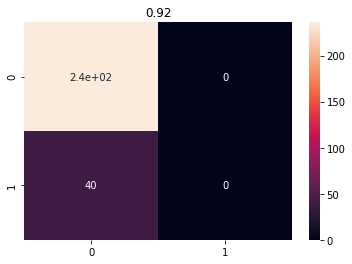

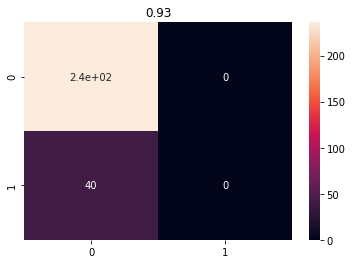

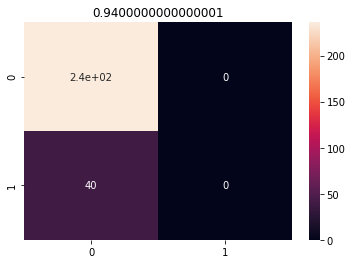

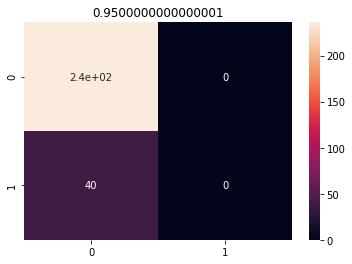

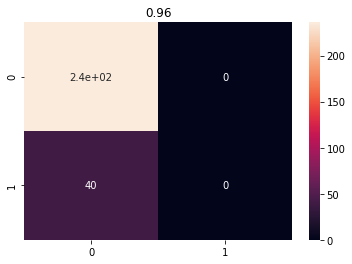

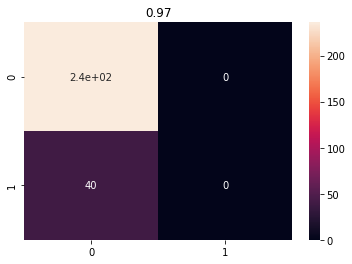

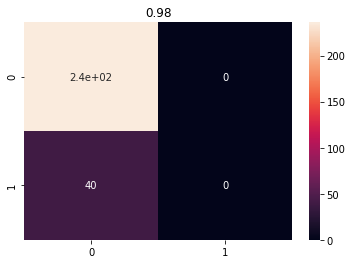

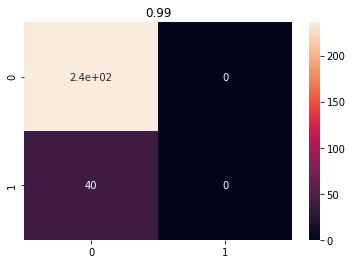

In [55]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = rand_rf_model.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
#     print(threshold, '================================================== \n', 
#           classification_report(y_val, predicted))
    plt.title(threshold)
    sns.heatmap(confusion_matrix(y_val, predicted), annot = True)
    plt.show()

## KNN

In [41]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_smote, y_train_smote)

KNeighborsClassifier()

In [42]:
y_pred_knn = knn_model.predict(X_val)

In [43]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = knn_model.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    print(threshold, '================================================== \n', 
          classification_report(y_val, predicted))

0.0 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.01 ================================================== 
               precision    recall  f1-score   support

           0       0.91      0.25      0.40       236
           1       0.16      0.85      0.27        40

    accuracy                           0.34       276
   macro avg       0.54      0.55      0.33       276
weighted avg       0.80      0.34      0.38       276

0.02 ================================================== 
               precision    recall  f1-score   support

           0       0.91      0.25      0.40       236
           1       0.16      0.85      0.27        40

    accur

0.26 ================================================== 
               precision    recall  f1-score   support

           0       0.89      0.43      0.58       236
           1       0.17      0.70      0.28        40

    accuracy                           0.47       276
   macro avg       0.53      0.56      0.43       276
weighted avg       0.79      0.47      0.53       276

0.27 ================================================== 
               precision    recall  f1-score   support

           0       0.89      0.43      0.58       236
           1       0.17      0.70      0.28        40

    accuracy                           0.47       276
   macro avg       0.53      0.56      0.43       276
weighted avg       0.79      0.47      0.53       276

0.28 ================================================== 
               precision    recall  f1-score   support

           0       0.89      0.43      0.58       236
           1       0.17      0.70      0.28        40

    accu

0.51 ================================================== 
               precision    recall  f1-score   support

           0       0.87      0.58      0.70       236
           1       0.16      0.47      0.24        40

    accuracy                           0.57       276
   macro avg       0.52      0.53      0.47       276
weighted avg       0.77      0.57      0.63       276

0.52 ================================================== 
               precision    recall  f1-score   support

           0       0.87      0.58      0.70       236
           1       0.16      0.47      0.24        40

    accuracy                           0.57       276
   macro avg       0.52      0.53      0.47       276
weighted avg       0.77      0.57      0.63       276

0.53 ================================================== 
               precision    recall  f1-score   support

           0       0.87      0.58      0.70       236
           1       0.16      0.47      0.24        40

    accu

0.78 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.81      0.84       236
           1       0.23      0.33      0.27        40

    accuracy                           0.74       276
   macro avg       0.55      0.57      0.56       276
weighted avg       0.78      0.74      0.76       276

0.79 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.81      0.84       236
           1       0.23      0.33      0.27        40

    accuracy                           0.74       276
   macro avg       0.55      0.57      0.56       276
weighted avg       0.78      0.74      0.76       276

0.8 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.81      0.84       236
           1       0.23      0.33      0.27        40

    accur

## Neural Network

In [44]:
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

In [45]:
ann_model = models.Sequential()
ann_model.add(layers.Dense(22, input_shape = (X_train_smote.shape), activation = 'relu'))
ann_model.add(layers.Dense(128, activation = 'relu'))
ann_model.add(layers.Dense(56, activation = 'relu'))
ann_model.add(layers.Dense(28, activation = 'relu'))
ann_model.add(layers.Dense(16, activation = 'relu'))
ann_model.add(layers.Dense(1, activation = 'sigmoid'))

# adam_opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

ann_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[metrics.Recall()])

In [46]:
ann_model.fit(X_train_smote, y_train_smote,
              batch_size=16,
              epochs=100,
              validation_split = .3)

Epoch 1/100
61/61 [==============================] - 0s 6ms/step - loss: 0.5769 - recall: 0.1095 - val_loss: 1.0048 - val_recall: 0.2179
Epoch 2/100
61/61 [==============================] - 0s 2ms/step - loss: 0.4761 - recall: 0.3066 - val_loss: 0.6680 - val_recall: 0.6223
Epoch 3/100
61/61 [==============================] - 0s 2ms/step - loss: 0.4294 - recall: 0.5000 - val_loss: 0.5331 - val_recall: 0.7264
Epoch 4/100
61/61 [==============================] - 0s 2ms/step - loss: 0.3925 - recall: 0.5876 - val_loss: 0.8163 - val_recall: 0.5206
Epoch 5/100
61/61 [==============================] - 0s 2ms/step - loss: 0.3556 - recall: 0.6168 - val_loss: 0.5796 - val_recall: 0.6780
Epoch 6/100
61/61 [==============================] - 0s 2ms/step - loss: 0.3151 - recall: 0.6642 - val_loss: 0.6183 - val_recall: 0.6973
Epoch 7/100
61/61 [==============================] - 0s 2ms/step - loss: 0.2899 - recall: 0.6934 - val_loss: 0.3390 - val_recall: 0.8547
Epoch 8/100
61/61 [======================

Epoch 55/100
61/61 [==============================] - 0s 3ms/step - loss: 1.7609e-04 - recall: 1.0000 - val_loss: 1.0590 - val_recall: 0.8208
Epoch 56/100
61/61 [==============================] - 0s 2ms/step - loss: 1.6636e-04 - recall: 1.0000 - val_loss: 1.0655 - val_recall: 0.8208
Epoch 57/100
61/61 [==============================] - 0s 2ms/step - loss: 1.5690e-04 - recall: 1.0000 - val_loss: 1.0873 - val_recall: 0.8208
Epoch 58/100
61/61 [==============================] - 0s 2ms/step - loss: 1.4753e-04 - recall: 1.0000 - val_loss: 1.0962 - val_recall: 0.8208
Epoch 59/100
61/61 [==============================] - 0s 2ms/step - loss: 1.3926e-04 - recall: 1.0000 - val_loss: 1.0991 - val_recall: 0.8208
Epoch 60/100
61/61 [==============================] - 0s 3ms/step - loss: 1.3120e-04 - recall: 1.0000 - val_loss: 1.1135 - val_recall: 0.8208
Epoch 61/100
61/61 [==============================] - 0s 3ms/step - loss: 1.2490e-04 - recall: 1.0000 - val_loss: 1.0982 - val_recall: 0.8208
Epoch 

In [47]:
y_pred_ann_model = ann_model.predict(X_val)
y_pred_ann_model

array([[1.05933309e-16],
       [1.20320022e-02],
       [1.42372469e-09],
       [2.43524939e-01],
       [4.74271786e-07],
       [4.32911349e-07],
       [7.76452680e-09],
       [6.19943918e-08],
       [1.62761853e-11],
       [8.48252111e-12],
       [1.03155106e-01],
       [1.00000000e+00],
       [2.97307849e-07],
       [3.36190760e-02],
       [1.16575807e-08],
       [2.42322683e-04],
       [1.95354223e-03],
       [1.00000000e+00],
       [3.47305615e-08],
       [2.58300847e-09],
       [2.04763433e-06],
       [2.09860151e-09],
       [7.23431555e-08],
       [1.00000000e+00],
       [3.16298897e-12],
       [1.48285925e-02],
       [2.24217772e-03],
       [2.67305586e-05],
       [5.35396293e-12],
       [8.25145019e-09],
       [1.19229639e-06],
       [9.97435689e-01],
       [1.50204866e-11],
       [6.67671500e-08],
       [3.77734512e-15],
       [6.38465139e-08],
       [2.07593998e-10],
       [6.37878106e-09],
       [4.84889746e-03],
       [1.59342587e-02],


In [48]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = ann_model.predict(X_val)
    predicted = (predicted_proba >= threshold).astype('int')
    print(threshold, '================================================== \n', 
          classification_report(y_val, predicted))

0.0 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.01 ================================================== 
               precision    recall  f1-score   support

           0       0.91      0.83      0.87       236
           1       0.35      0.53      0.42        40

    accuracy                           0.79       276
   macro avg       0.63      0.68      0.65       276
weighted avg       0.83      0.79      0.81       276

0.02 ================================================== 
               precision    recall  f1-score   support

           0       0.91      0.85      0.88       236
           1       0.36      0.50      0.42        40

    accur

0.24 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       236
           1       0.41      0.42      0.42        40

    accuracy                           0.83       276
   macro avg       0.66      0.66      0.66       276
weighted avg       0.83      0.83      0.83       276

0.25 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       236
           1       0.40      0.40      0.40        40

    accuracy                           0.83       276
   macro avg       0.65      0.65      0.65       276
weighted avg       0.83      0.83      0.83       276

0.26 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       236
           1       0.40      0.40      0.40        40

    accu

0.46 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       236
           1       0.41      0.40      0.41        40

    accuracy                           0.83       276
   macro avg       0.65      0.65      0.65       276
weighted avg       0.83      0.83      0.83       276

0.47000000000000003 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       236
           1       0.41      0.40      0.41        40

    accuracy                           0.83       276
   macro avg       0.65      0.65      0.65       276
weighted avg       0.83      0.83      0.83       276

0.48 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       236
           1       0.41      0.40      0.41     

0.6900000000000001 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       236
           1       0.44      0.40      0.42        40

    accuracy                           0.84       276
   macro avg       0.67      0.66      0.66       276
weighted avg       0.83      0.84      0.84       276

0.7000000000000001 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       236
           1       0.44      0.40      0.42        40

    accuracy                           0.84       276
   macro avg       0.67      0.66      0.66       276
weighted avg       0.83      0.84      0.84       276

0.71 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       236
           1       0.44      0.40  

0.92 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       236
           1       0.45      0.38      0.41        40

    accuracy                           0.84       276
   macro avg       0.68      0.65      0.66       276
weighted avg       0.83      0.84      0.84       276

0.93 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       236
           1       0.45      0.38      0.41        40

    accuracy                           0.84       276
   macro avg       0.68      0.65      0.66       276
weighted avg       0.83      0.84      0.84       276

0.9400000000000001 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.93      0.91       236
           1       0.47      0.38      0.42      

## XGBoost Classfiier

In [49]:
xgb_model = XGBClassifier(random_state = 0)

In [50]:
xgb_model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
y_pred_xgb = xgb_model.predict(X_val)

In [52]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = xgb_model.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    print(threshold, '================================================== \n', 
          classification_report(y_val, predicted))

0.0 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.01 ================================================== 
               precision    recall  f1-score   support

           0       0.95      0.51      0.66       236
           1       0.22      0.82      0.35        40

    accuracy                           0.56       276
   macro avg       0.58      0.67      0.51       276
weighted avg       0.84      0.56      0.62       276

0.02 ================================================== 
               precision    recall  f1-score   support

           0       0.92      0.56      0.70       236
           1       0.21      0.70      0.33        40

    accur

0.48 ================================================== 
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       236
           1       0.43      0.33      0.37        40

    accuracy                           0.84       276
   macro avg       0.66      0.63      0.64       276
weighted avg       0.82      0.84      0.83       276

0.49 ================================================== 
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       236
           1       0.43      0.33      0.37        40

    accuracy                           0.84       276
   macro avg       0.66      0.63      0.64       276
weighted avg       0.82      0.84      0.83       276

0.5 ================================================== 
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       236
           1       0.43      0.33      0.37        40

    accur

0.79 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       236
           1       0.50      0.20      0.29        40

    accuracy                           0.86       276
   macro avg       0.69      0.58      0.60       276
weighted avg       0.82      0.86      0.83       276

0.8 ================================================== 
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       236
           1       0.47      0.17      0.25        40

    accuracy                           0.85       276
   macro avg       0.67      0.57      0.59       276
weighted avg       0.81      0.85      0.82       276

0.81 ================================================== 
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       236
           1       0.47      0.17      0.25        40

    accur